# Sentiment Analysis

## Import Libraries And Load Datasets

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import SnowballStemmer
from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score

In [4]:
# Load the Sentiment Analysis dataset into a DataFrame
sentiment_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')


## Data Exploration
Explored the dataset to understand its structure, feature distribution, and potential insights.

Identify key variables such as text content and sentiment labels.

In [5]:
# Display the first few rows of the DataFrame to understand its structure
print("Dataset Structure:")
print(sentiment_df.head())


Dataset Structure:
   polarity of tweet   id of the tweet             date of the tweet  \
0                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
1                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
2                   0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
3                   0       1467811193  Mon Apr 06 22:19:57 PDT 2009   
4                   0       1467811372  Mon Apr 06 22:20:00 PDT 2009   

      query           user                                 text of the tweet   
0  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
1  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  
2  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire   
3  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....  
4  NO_QUERY       joy_wolf                      @Kwesidei not the whole crew   


In [6]:
# Get information about the dataset such as column names, data types, and non-null counts
print("\nDataset Information:")
print(sentiment_df.info())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB
None


In [7]:
sentiment_df.describe()

,polarity of tweet,id of the tweet
count,1.048572e+06,1.048572e+06
mean,9.482458e-01,1.976168e+09
std,1.701122e+00,2.300567e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990870e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [8]:
# Check the size of the dataset (number of rows and columns)
num_rows, num_columns = sentiment_df.shape
print("\nDataset Size:")
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)



Dataset Size:
Number of Rows: 1048572
Number of Columns: 6


In [9]:
sentiment_df.isnull().sum()

polarity of tweet     0
id of the tweet       0
date of the tweet     0
query                 0
user                  0
text of the tweet     0
dtype: int64

In [10]:
# Identify key variables such as text content and sentiment labels
text_column = 'text of the tweet '  # Assuming the column containing the text content is named 'text'
sentiment_label_column = 'polarity of tweet '  # Assuming the column containing the sentiment labels is named 'sentiment'

# Print unique values of sentiment labels to understand the sentiment classes/categories
print("\nUnique Sentiment Labels:")
print(sentiment_df[sentiment_label_column].unique())

# Print unique values of text content to understand the data
print("\nUnique Text Content:")
print(sentiment_df[text_column].unique())


Unique Sentiment Labels:
[0 4]

Unique Text Content:
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 'my whole body feels itchy and like its on fire ' ...
 '@ShaDeLa same here  say it like from the Terminiator movies. comes off like just 3 words. :-D'
 '@DestinyHope92 im great thaanks  wbuu?'
 'cant wait til her date this weekend ']


#### Changing the Name of the Columns for better handeling and Understanding

In [11]:
print(sentiment_df.columns)


Index(['polarity of tweet ', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet '],
      dtype='object')


In [12]:
# Assign new column names
new_column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Set the new column names
sentiment_df.columns = new_column_names

# Display the DataFrame with the new column names
print(sentiment_df.head())

   sentiment          id                          date     query  \
0          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   

            user                                               text  
0  scotthamilton  is upset that he can't update his Facebook by ...  
1       mattycus  @Kenichan I dived many times for the ball. Man...  
2        ElleCTF    my whole body feels itchy and like its on fire   
3         Karoli  @nationwideclass no, it's not behaving at all....  
4       joy_wolf                      @Kwesidei not the whole crew   


In [13]:
print(sentiment_df.columns)

Index(['sentiment', 'id', 'date', 'query', 'user', 'text'], dtype='object')


#### Plotting the distribution of sentiment labels from the DataFrame using a bar plot.


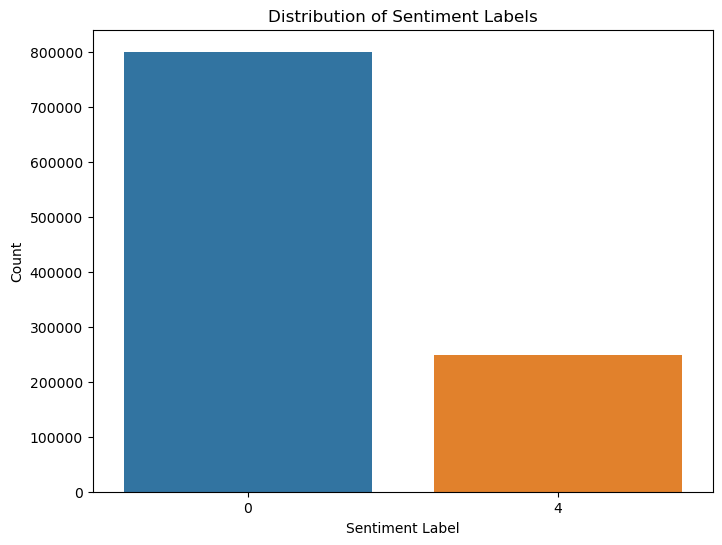

In [14]:
# Set the size of the plot
plt.figure(figsize=(8, 6))

# Plot the distribution of sentiment labels
sns.countplot(x='sentiment', data=sentiment_df)

# Set plot title and labels
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

# Show plot
plt.show()

In [15]:
#Dropping the duplicate rows 
sentiment_df = sentiment_df.drop_duplicates('text')

### EDA 
- Conduct exploratory data analysis to gain insights into the distribution of sentiment labels.
- Visualize the distribution using histograms or pie charts to understand the balance of sentiment classes.

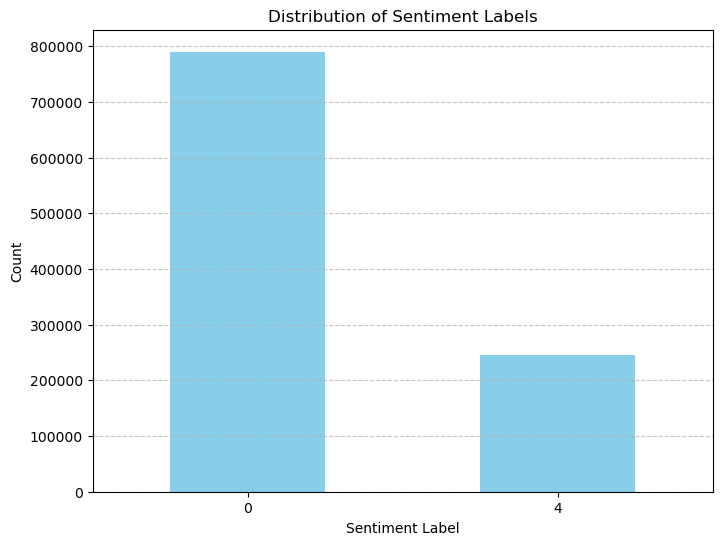

----------------------------------------------------------------------


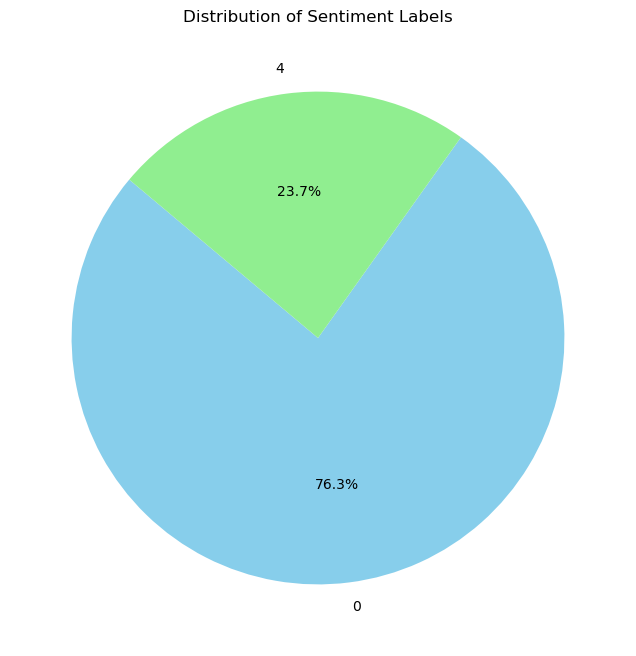

In [16]:
# Count the occurrences of each sentiment label
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Plot the distribution of sentiment labels using a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print('----------------------------------------------------------------------')
# Plot the distribution of sentiment labels using a pie chart
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=140)
plt.title('Distribution of Sentiment Labels')
plt.ylabel('')
plt.show()

### Data Preprocessing

- initialized a WordNet Lemmatizer and define a list of punctuation characters to be removed.
- created a text preprocessing function, preprocess_text, which performs various tasks such as lowercasing, removing special characters and numbers, tokenizing, removing stop words, removing punctuation, and lemmatization.
- The function prepares text for natural language processing tasks by standardizing and cleaning it.

In [4]:
train_df = pd.read_csv('train.csv', encoding='ISO-8859-1')

In [19]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [20]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
stuff_to_be_removed = list(punctuation)

def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          # converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       # removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                          # removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text)                                         # removing other symbols like ^ except '
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    
    return text1 

In [22]:
data_cleaned = pd.DataFrame()
train_df['text'] = train_df['text'].apply(textprocessing)
train_df['text'].head()



0                        i d have respond if i were go
1           sooo sad i will miss you here in san diego
2                                  my boss is bulli me
3                          what interview leav me alon
4    son of whi couldn t they put them on the relea...
Name: text, dtype: object

### Model Selection 

- Reading training and testing datasets from CSV files and handling missing values by dropping rows where the 'text' and 'sentiment' columns are NaN.
- Extracting features (text data) and labels (sentiment) from the datasets to prepare them for model training and evaluation.
- Utilizing TF-IDF vectorization to convert the text data into numerical features, transforming both the training and testing datasets to TF-IDF representations for further analysis and model training.

In [2]:
from sklearn.naive_bayes import MultinomialNB

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
# Read the training and testing datasets
train_data = pd.read_csv('train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('test.csv', encoding='ISO-8859-1')

# Handle missing values if any
train_data.dropna(subset=['text', 'sentiment'], inplace=True)
test_data.dropna(subset=['text', 'sentiment'], inplace=True)

# Extract features and labels from the datasets
X_train, y_train = train_data['text'], train_data['sentiment']
X_test, y_test = test_data['text'], test_data['sentiment']

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Naive Bayes model And Support Vector Machine model

#####  Naive Bayes Model:
- trained a Multinomial Naive Bayes classifier (nb_classifier) on TF-IDF transformed training data (X_train_tfidf) and corresponding labels (y_train).
- defined and apply an evaluation function (evaluate_model) to compute accuracy and generate a classification report for the Naive Bayes model on the TF-IDF transformed testing data (X_test_tfidf) and corresponding labels (y_test).



In [5]:

# Train and evaluate the Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)

print("Naive Bayes Model Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Model Classification Report:")
print(classification_report(y_test, y_pred_nb))



Naive Bayes Model Accuracy: 0.6247877758913413
Naive Bayes Model Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.37      0.50      1001
     neutral       0.53      0.87      0.66      1430
    positive       0.82      0.54      0.65      1103

    accuracy                           0.62      3534
   macro avg       0.71      0.59      0.60      3534
weighted avg       0.69      0.62      0.61      3534



##### Support Vector Machine Model:
- trained a Support Vector Machine classifier (svm_classifier) with a linear kernel on TF-IDF transformed training data (X_train_tfidf) and corresponding labels (y_train).
- utilized the same evaluation function (evaluate_model) to calculate accuracy and produce a classification report for the SVM model on the TF-IDF transformed testing data (X_test_tfidf) and corresponding labels (y_test).

In [ ]:

# Train and evaluate the SVM model
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)
y_pred_svm = svm_classifier.predict(X_test_tfidf)

print("Support Vector Machine Model Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Support Vector Machine Model Classification Report:")
print(classification_report(y_test, y_pred_svm))


### LSTM Model

- Tokenize and convert text data into numerical sequences using Keras' Tokenizer.
- Pad sequences to ensure uniform length for input to the LSTM model.
- Convert sentiment labels to categorical format for multi-class classification.
- Split dataset into training and testing sets.
- Build, compile, train, and evaluate an LSTM model for sentiment analysis.

In [ ]:
# Tokenize the text data
max_words = 10000  # Max number of words to tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Padding sequences to ensure uniform length
max_seq_length = 100  # Max sequence length
X = pad_sequences(sequences, maxlen=max_seq_length)

# Convert sentiment labels to categorical labels
y = pd.get_dummies(train_df['sentiment']).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 50  # Dimension of word embeddings
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
lstm_units = 128  # Number of LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)




Epoch 1/10


687/687 [==============================] - 90s 118ms/step - loss: 0.8225 - accuracy: 0.6244 - val_loss: 0.7093 - val_accuracy: 0.6934
Epoch 2/10
687/687 [==============================] - 76s 111ms/step - loss: 0.5792 - accuracy: 0.7649 - val_loss: 0.6754 - val_accuracy: 0.7120
Epoch 3/10
687/687 [==============================] - 74s 108ms/step - loss: 0.4723 - accuracy: 0.8168 - val_loss: 0.7307 - val_accuracy: 0.6981
Epoch 4/10
687/687 [==============================] - 74s 107ms/step - loss: 0.3994 - accuracy: 0.8479 - val_loss: 0.7742 - val_accuracy: 0.7031
Epoch 5/10
687/687 [==============================] - 75s 108ms/step - loss: 0.3336 - accuracy: 0.8765 - val_loss: 0.8509 - val_accuracy: 0.6991
Epoch 6/10
687/687 [==============================] - 75s 109ms/step - loss: 0.2772 - accuracy: 0.8989 - val_loss: 0.9765 - val_accuracy: 0.6794
Epoch 7/10
468/687 [===================>..........] - ETA: 22s - loss: 0.2222 - accuracy: 0.9225

### Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV


- Defined hyperparameters grid for Naive Bayes: Specify a grid of alpha values for Laplace smoothing parameter.

- Initialize GridSearchCV for Naive Bayes: Create a GridSearchCV object for Multinomial Naive Bayes classifier using the defined parameter grid, 5-fold cross-validation, and accuracy as the scoring metric.

- Perform grid search on Naive Bayes: Execute the grid search to find the best combination of hyperparameters that maximizes accuracy on the training data. Then print out the best hyperparameters and corresponding accuracy achieved by the Naive Bayes model.

In [11]:

# Define hyperparameters grid for Naive Bayes
nb_param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Initialize GridSearchCV for Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='accuracy')

# Perform grid search on Naive Bayes
nb_grid_search.fit(X_train_tfidf, y_train)

# Print best hyperparameters for Naive Bayes
print("Best Hyperparameters for Naive Bayes:", nb_grid_search.best_params_)
print("Best Accuracy for Naive Bayes:", nb_grid_search.best_score_)



Best Hyperparameters for Naive Bayes: {'alpha': 0.5}
Best Accuracy for Naive Bayes: 0.6236171761280931


- Define hyperparameters grid for SVM: Specify a grid of C (regularization parameter), gamma (kernel coefficient), and kernel type (linear or radial basis function) for Support Vector Machine.

- Initialize GridSearchCV for SVM: Create a GridSearchCV object for Support Vector Machine classifier using the defined parameter grid, 5-fold cross-validation, and accuracy as the scoring metric.

- Perform grid search on SVM: Execute the grid search to find the best combination of hyperparameters that maximizes accuracy on the training data. Then print out the best hyperparameters and corresponding accuracy achieved by the SVM model.

In [ ]:
# Define hyperparameters grid for SVM
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Initialize GridSearchCV for SVM
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')

# Perform grid search on SVM
svm_grid_search.fit(X_train_tfidf, y_train)

# Print best hyperparameters for SVM
print("\nBest Hyperparameters for SVM:", svm_grid_search.best_params_)
print("Best Accuracy for SVM:", svm_grid_search.best_score_)


### cross validation

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
# Initialize Naive Bayes model with best hyperparameters
best_nb_model = MultinomialNB(alpha=nb_grid_search.best_params_['alpha'])

# Perform k-fold cross-validation for Naive Bayes
nb_cv_scores = cross_val_score(best_nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for Naive Bayes
print("Cross-Validation Scores for Naive Bayes:", nb_cv_scores)
print("Mean Cross-Validation Accuracy for Naive Bayes:", nb_cv_scores.mean())




Cross-Validation Scores for Naive Bayes: [0.61990539 0.62154294 0.62700146 0.62445415 0.62518195]
Mean Cross-Validation Accuracy for Naive Bayes: 0.6236171761280931


In [ ]:
# Initialize SVM model with best hyperparameters
best_svm_model = SVC(C=svm_grid_search.best_params_['C'], gamma=svm_grid_search.best_params_['gamma'], kernel=svm_grid_search.best_params_['kernel'])

# Perform k-fold cross-validation for SVM
svm_cv_scores = cross_val_score(best_svm_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for SVM
print("\nCross-Validation Scores for SVM:", svm_cv_scores)
print("Mean Cross-Validation Accuracy for SVM:", svm_cv_scores.mean())

### Model Interpretability
- Training a decision tree classifier or random forest classifier: We're preparing to visualize the feature importances of a trained random forest classifier.

- Initializing and training the Random Forest classifier with best hyperparameters: Using scikit-learn's RandomForestClassifier, we create an instance with specified hyperparameters (in this case, 100 estimators and a maximum depth of 10) and train it on the TF-IDF transformed training data (X_train_tfidf) and corresponding labels (y_train).

- Obtaining feature importances: After training the random forest classifier, we extract the feature importances, which indicate the relative importance of each feature in making predictions.

- Sorting feature importances: We sort the feature importances in descending order to identify the most important features.

- Plotting the top N most important features: Finally, we visualize the top N most important features using a bar plot, where each bar represents a feature, its importance is represented by the height of the bar, and the feature names are displayed on the x-axis. We set N to 20 in this example.

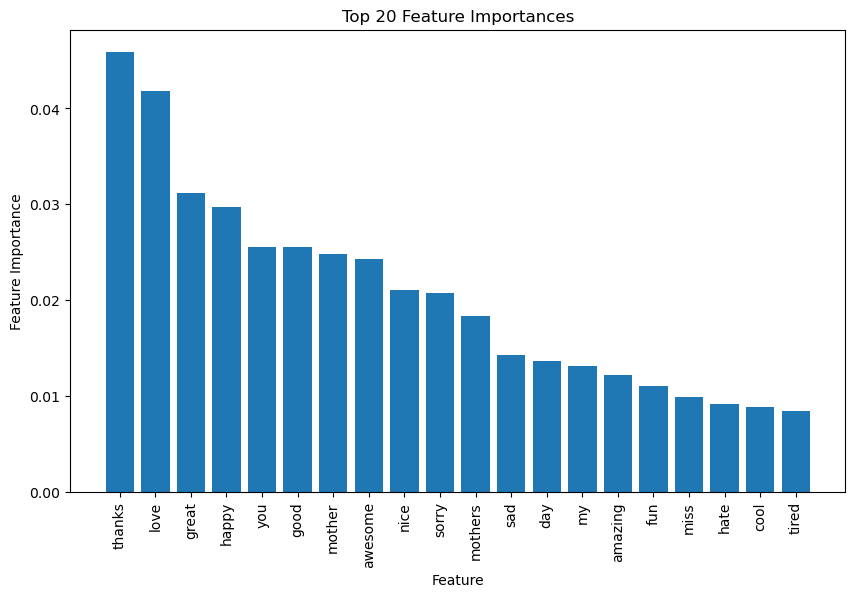

In [5]:
import matplotlib.pyplot as plt

# Train a decision tree classifier or random forest classifier
# Use the best hyperparameters obtained from hyperparameter tuning

# Example:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest classifier with best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
best_rf_model.fit(X_train_tfidf, y_train)

# Plot feature importances
feature_importances = best_rf_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the top N most important features
N = 20
plt.figure(figsize=(10, 6))
plt.bar(range(N), sorted_feature_importances[:N], tick_label=sorted_feature_names[:N])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Top {} Feature Importances'.format(N))
plt.show()


- Initialize LIME explainer: Create a LimeTabularExplainer object to explain predictions using LIME (Local Interpretable Model-agnostic Explanations). Pass the TF-IDF transformed training data as the data to explain, along with feature names and class names.

- Choose a random instance to explain: Select a random instance from the test dataset, retrieve its text and label for explanation.

- Explain the instance prediction using LIME: Generate an explanation for the selected instance's prediction by passing the instance's TF-IDF representation, the predict_proba function of the trained Random Forest model, specifying the number of features to include in the explanation, and choosing the top label to explain.

In [8]:
pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---------- ---------------------------- 71.7/275.7 kB 1.3 MB/s eta 0:00:01
     ---------------------------- --------- 204.8/275.7 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=faed6dd929870cbcd7efe0e4a4cc656a6ef8b639bc908aad463a7b4765013402
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import lime
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_tfidf.toarray(), feature_names=feature_names, class_names=['Negative', 'Positive'])

# Choose a random instance to explain
instance_idx = np.random.randint(0, len(X_test_tfidf))
instance_text = X_test.iloc[instance_idx]
instance_label = y_test.iloc[instance_idx]

# Explain the instance prediction using LIME
explanation = explainer.explain_instance(X_test_tfidf[instance_idx].toarray().reshape(-1), best_rf_model.predict_proba, num_features=10, top_labels=1)

# Show explanation
explanation.show_in_notebook()


### Evaluation Metrics 

- Plotting precision-recall curve: Generate and display the precision-recall curve based on true labels and predicted probabilities.
- Plotting ROC curve: Generate and display the ROC curve based on true labels and predicted probabilities.
- Evaluating confusion matrix: Compute and print the confusion matrix based on true labels and predicted binary outcomes.


Confusion Matrix:
[[2 0]
 [0 3]]


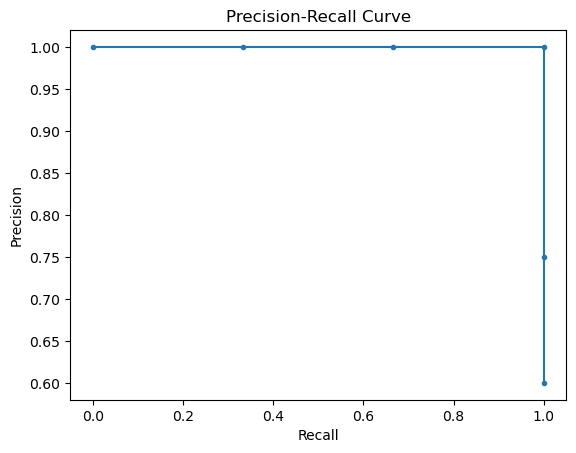

In [5]:

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# Evaluate confusion matrix
def evaluate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Evaluate precision-recall curve
def evaluate_precision_recall_curve(y_true, y_pred_prob):
    plot_precision_recall_curve(y_true, y_pred_prob)



# Replace these with your actual predictions and scores
y_true = [0, 1, 0, 1, 1]
y_pred_prob = [0.1, 0.8, 0.3, 0.9, 0.6]  # Predicted probabilities

# Calculate binary predictions from probabilities
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Evaluate confusion matrix
evaluate_confusion_matrix(y_true, y_pred)

# Evaluate precision-recall curve
evaluate_precision_recall_curve(y_true, y_pred_prob)

